In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib as mpl
import sqlite3, os, sys, pickle
import os.path as osp 



In [2]:

# path = "//groups/hep/pcs557/databases/dev_lvl7_mu_nu_e_classification_v003/data/dev_lvl7_mu_nu_e_classification_v003_unscaled.db"
# transform = "/groups/hep/johannbs/data/transformers2.pkl"
# with sqlite3.connect(path) as conn:
#     targets = pd.read_sql("select pid from truth", conn)

In [3]:
OscNext_path = osp.join("..", "data", "features", "OscNextCommonSplit_full")
OscNext_sample = pd.read_pickle(osp.join(OscNext_path, "train0.dat"))

MuonGun_path = osp.join("..", "data", "features", "MuonGun")
MuonGun_sample = pd.read_pickle(osp.join(MuonGun_path, "train0.dat"))
# MuonGun_sample2 = pd.read_pickle(osp.join(MuonGun_path, "train50000.dat"))


In [4]:
id = MuonGun_sample[1][:, 0]

In [5]:
with sqlite3.connect("/groups/hep/johannbs/data/rasmus_classification_muon_3neutrino_3mio.db") as conn:
    energy = pd.read_sql(f"select energy_log10 from truth where event_no in {tuple(id)}", conn)

In [6]:
transformers = pd.read_pickle("/groups/hep/johannbs/data/transformers2.pkl")

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

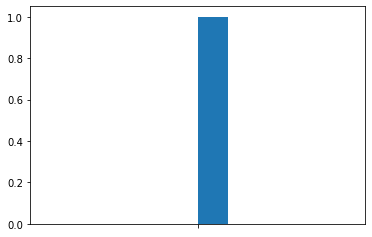

In [7]:
plt.hist(_)

In [8]:
pos_OscNext = np.concatenate(OscNext_sample[0])[:, :3]
pos_MuonGun = np.concatenate(MuonGun_sample[0])[:, :3]

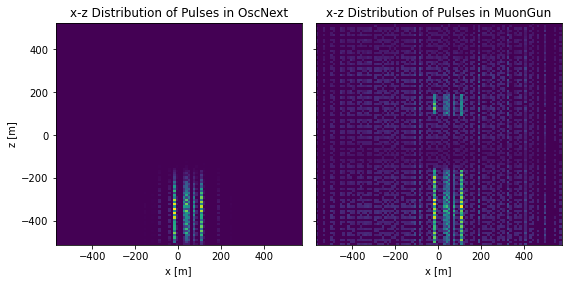

In [9]:
fig, ax = plt.subplots(figsize = (8 , 6), ncols = 2, sharey = True)

# lims = ((-400, 400), ())

ax[0].set_title("x-z Distribution of Pulses in OscNext")
ax[0].hist2d(pos_OscNext[:, 0], pos_OscNext[:, 2], bins = 100)
ax[0].set_aspect("equal")
ax[0].set_xlabel("x [m]")
ax[0].set_ylabel("z [m]")



ax[1].set_title("x-z Distribution of Pulses in MuonGun")
ax[1].hist2d(pos_MuonGun[:, 0], pos_MuonGun[:, 2], bins = 100);
# ax[1].set_ylabel("z [m]")
ax[1].set_xlabel("x [m]")

ax[1].set_aspect("equal")
fig.tight_layout()

In [10]:
fig.savefig(osp.join("..", "figures", "xz_distributions.pdf"))

In [11]:
db_path  = "/groups/hep/johannbs/data/rasmus_classification_muon_3neutrino_3mio.db"
set_path =  "/groups/hep/johannbs/data/rasmus_classification_muon_1500k_sets.pkl"

test_id  = pd.read_pickle(set_path)['test']
with sqlite3.connect(db_path) as conn:
    df = pd.read_sql(f"select * from truth where event_no in {tuple(test_id)}", conn).sort_values("event_no").set_index("event_no", drop = True)
transforms = pd.read_pickle("/groups/hep/johannbs/data/transformers2.pkl")
for col in df.columns:
    if col in list(transforms['truth'].keys()):
        df[col]     = transforms["truth"][col].inverse_transform(np.array(df[col]).reshape(-1, 1)).flatten()


In [12]:
energy = df['energy_log10']


In [13]:
with sqlite3.connect(db_path) as conn:
    Ns = pd.read_sql(f"select event_no from features where event_no in {tuple(test_id)} and SRTInIcePulses = 1", conn)

In [14]:
Ns = Ns.sort_values("event_no").value_counts()

In [15]:
Ns = np.log10(Ns.sort_values("index"))

In [16]:
Ns_MuonGun, energy_MuonGun = Ns, energy

array([27026074, 18018600, 21018872, ..., 11052402, 12450601, 12504006])

In [24]:
db_path  = "/groups/hep/pcs557/databases/dev_lvl7_mu_nu_e_classification_v003/data/dev_lvl7_mu_nu_e_classification_v003_unscaled.db"
set_path = "/groups/hep/pcs557/databases/dev_lvl7_mu_nu_e_classification_v003/meta/sets.pkl"

test_id  = pd.read_pickle(set_path)['test']
with sqlite3.connect(db_path) as conn:
    df = pd.read_sql(f"select * from truth where event_no in {tuple(np.array(test_id).flatten())}", conn).sort_values("event_no").set_index("event_no", drop = True)

energy = df['energy_log10']

with sqlite3.connect(db_path) as conn:
    Ns = pd.read_sql(f"select event_no from features where event_no in {tuple(np.array(test_id).flatten())}", conn)

Ns = Ns.sort_values("event_no").value_counts()
Ns = np.log10(Ns.sort_values("index"))

Ns_OscNExt, energy_OscNext = Ns, energy

In [33]:
Ns_OscNext = Ns[:50000]
energy_OscNext = energy[:50000]

In [34]:
Ns_MuonGun

event_no 
140166656    0.301030
139736073    0.301030
139184359    0.477121
138851678    0.477121
140342847    0.477121
               ...   
139635917    3.379668
138854038    3.394627
139199327    3.416141
138919727    3.465234
140061648    3.540830
Length: 150000, dtype: float64

In [35]:
Ns_OscNext

event_no
10882025    0.90309
6279402     0.90309
1317163     0.90309
10086189    0.90309
1317135     0.90309
             ...   
9706642     0.90309
7436870     0.90309
631448      0.90309
3719781     0.90309
7436944     0.90309
Length: 50000, dtype: float64

In [14]:
name_oscnext = ["OscNext" for i in range(len(Es_MuonGun))]
name_muongun = ["MuonGun" for i in range(len(Es_OscNext))]


dict = {
    "log(E)": np.concatenate([Es_OscNext, Es_MuonGun]),
    "log(N)": np.concatenate([Ns_OscNext, Ns_MuonGun]),
    "name":   name_oscnext + name_muongun
}

df = pd.DataFrame(dict)


In [16]:
plt.hist(Es_OscNext)
plt.hist(transformers['truth']["energy_log10"].inverse_transform(Es_MuonGun.reshape(1, -1)))

In [ ]:
plt.hist(df['log(E)'][df.name == "MuonGun"], histtype = "step")
plt.hist(df['log(E)'][df.name == "OscNext"], histtype = "step")

In [ ]:

from seaborn import jointplot

fig = jointplot(data = df, x = "log(N)", y = "log(E)", hue = "name", kind = "kde", xlim = (1., 3.), ylim = (0., 3.))

In [13]:
fig.set(xlim = (1., 3.), ylim = (0. , 3.))

AttributeError: 'JointGrid' object has no attribute 'set'

In [10]:
_.savefig("../figures/pairplot_N_E.pdf")

In [7]:
targets.pid.value_counts()

NameError: name 'targets' is not defined

In [19]:
len(targets)

8291804

In [15]:
targets.pid

0         13
1         13
2         13
3         13
4         13
          ..
160408    13
160409    13
160410    13
160411    13
160412    13
Name: pid, Length: 160413, dtype: int64

In [ ]:
transformers = pickle.load(open(transform, "rb"))
transformers["truth"].keys()

In [ ]:
for col in targets.columns:
    if col in transformers["truth"].keys():
        targets[col] = transformers["truth"][col].inverse_transform(np.array(targets[col]).reshape(1, -1)).T

In [ ]:
targets.hist("azimuth", bins = 100)

In [ ]:
fig, ax = plt.subplots(figsize = (4, 9), nrows = 3)
ax = ax.flatten()

fig.suptitle("MuonGun Distributions")

ax = ax[0]
ax.hist(targets.energy_log10, bins = 100, histtype = "step")
ax.set_title(r"Energy $\log_{10}$ Distribution")
ax.set_xlabel(r"$\log_{10}(E)$")
ax.set_ylabel("Frequency")


ax = ax[1]
ax.hist(targets.azimuth, bins = 100, histtype = "step")
ax.set_title("Azimuth Distribution")
ax.set_xlabel("Azumuth [rad]")
ax.set_ylabel("Frequency")

ax = ax[2]
ax.hist(targets.zenith, bins = 100, histtype = "step")
ax.set_title("Zenith Distribution")
ax.set_xlabel("Zenith [rad]")
ax.set_ylabel("Frequency")